In [212]:
import json
from collections import defaultdict
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import scipy.stats as stats
import gzip
import scipy.sparse as sparse

from matplotlib.patches import Rectangle
import statsmodels.api as sm


In [213]:
#family_id = '11002'
#family_id = '11089'
ped_file = '../../DATA/ssc/ssc.ped'
chroms = [str(x) for x in range(1, 23)]

In [214]:
colors=['#ef6c00', '#4db6ac']

In [215]:
ssc_old_id_to_new_id = dict()
with open('../data/ssc.id_map.from.repository', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        ssc_old_id_to_new_id[pieces[1]] = pieces[0]
        ssc_old_id_to_new_id[pieces[1].replace('.', '_')] = pieces[0]

In [216]:
# pull affected status
# (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            if child_id in ssc_old_id_to_new_id and m_id in ssc_old_id_to_new_id and f_id in ssc_old_id_to_new_id:
                child_id = ssc_old_id_to_new_id[child_id]
                f_id = ssc_old_id_to_new_id[f_id]
                m_id = ssc_old_id_to_new_id[m_id]
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

                if (fam_id, m_id, f_id) not in fam_to_inds:
                    fam_to_inds[(fam_id, m_id, f_id)] = [m_id, f_id]
                fam_to_inds[(fam_id, m_id, f_id)].append(child_id)
                
print('ped loaded')
print('children', len(child_id_to_affected))

ped loaded
children 1037


# pull our deletions

In [217]:
# pull deletions
deletions = []
with open('../phased_ssc_del/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited']:
            for child in d['trans']:
                if '%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child) in d:
                    deletions.append({
                                'family': d['family'],
                                'child': ssc_old_id_to_new_id[child],
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': ssc_old_id_to_new_id[d['mother']],
                                'father': ssc_old_id_to_new_id[d['father']],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers': d['num_markers'],
                                'num_markers_aCGH': d['%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child)],
                                'med_aCGH': d['%s_med_aCGH' % ssc_old_id_to_new_id.get(child, child)]
                        })
print(len(deletions))

48039


# pull sebat deletions

In [218]:
# pull deletions
sebat_deletions = []
with open('../phased_ssc.sebat_del/deletions.json') as f:
    for d in json.load(f):
        if d['is_inherited']:
            for child in d['trans']:
                if '%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child) in d:
                    sebat_deletions.append({
                                'family': d['family'],
                                'child': child,
                                'chrom': d['chrom'],
                                'start_pos': d['start_pos'],
                                'end_pos': d['end_pos'],
                                'length': d['length'],
                                'opt_start_pos': d['opt_start_pos'],
                                'opt_end_pos': d['opt_end_pos'],
                                'is_mat': d['is_mat'],
                                'is_pat': d['is_pat'],
                                'mother': d['mother'],
                                'father': d['father'],
                                'is_inherited': d['is_inherited'],
                                'is_denovo': d['is_denovo'],
                                'num_markers_ssc': d['num_markers_ssc'],
                                'num_markers_aCGH': d['%s_num_markers_aCGH' % ssc_old_id_to_new_id.get(child, child)],
                                'med_aCGH': d['%s_med_aCGH' % ssc_old_id_to_new_id.get(child, child)]
                        })
print(len(sebat_deletions))

426123


In [219]:
#remove deletions that aren't inherited
deletions = [d for d in deletions if d['is_inherited']]
print('remaining deletions', len(deletions))

sebat_deletions = [d for d in sebat_deletions if d['is_inherited']]
print('remaining deletions', len(sebat_deletions))

remaining deletions 48039
remaining deletions 426123


In [220]:
#remove deletions <100bp
deletions = [d for d in deletions if d['length']>=100]
print('remaining deletions', len(deletions))

sebat_deletions = [d for d in sebat_deletions if d['length']>=100]
print('remaining deletions', len(sebat_deletions))

remaining deletions 40423
remaining deletions 426123


In [221]:
chrom_to_interval_starts, chrom_to_interval_ends = defaultdict(list), defaultdict(list)
with open('../data/filtered_regions_hg19.bed', 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[0][3:] in chroms:
            chrom_to_interval_starts[pieces[0][3:]].append(int(pieces[1]))
            chrom_to_interval_ends[pieces[0][3:]].append(int(pieces[2]))
            
for chrom in [str(x) for x in range(1, 23)]:
    chrom_to_interval_starts[chrom] = np.array(chrom_to_interval_starts[chrom])
    chrom_to_interval_ends[chrom] = np.array(chrom_to_interval_ends[chrom])
         
excluded_deletions = set()
for i, d in enumerate(deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
deletions = [d for i, d in enumerate(deletions) if i not in excluded_deletions]
print('remaining deletions', len(deletions))

excluded_deletions = set()
for i, d in enumerate(sebat_deletions):
    starts, ends = chrom_to_interval_starts[d['chrom']], chrom_to_interval_ends[d['chrom']]
    overlaps = np.clip(np.minimum(d['end_pos'], ends) - np.maximum(d['start_pos'], starts), 0, None)
    if np.sum(overlaps)/d['length'] > 0.66:
        excluded_deletions.add(i)
print('excluded deletions', len(excluded_deletions)) 
sebat_deletions = [d for i, d in enumerate(sebat_deletions) if i not in excluded_deletions]
print('remaining deletions', len(sebat_deletions))

excluded deletions 17369
remaining deletions 23054
excluded deletions 14249
remaining deletions 411874


# compare

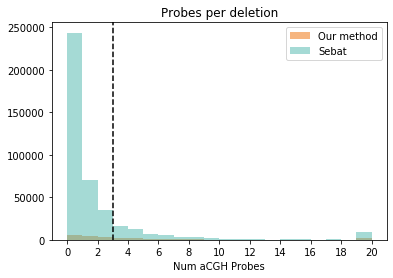

In [222]:
plt.hist(np.clip([d['num_markers_aCGH'] for d in deletions], 0, 20), 
         alpha=0.5, bins=np.arange(0, 21, 1), color=colors[0], label='Our method')
plt.hist(np.clip([d['num_markers_aCGH'] for d in sebat_deletions], 0, 20), 
         alpha=0.5, bins=np.arange(0, 21, 1), color=colors[1], label='Sebat')
plt.legend()
plt.axvline(3, color='black', linestyle='--')
plt.xticks(np.arange(0, 21, 2))
plt.xlabel('Num aCGH Probes')
plt.title('Probes per deletion')
plt.show()

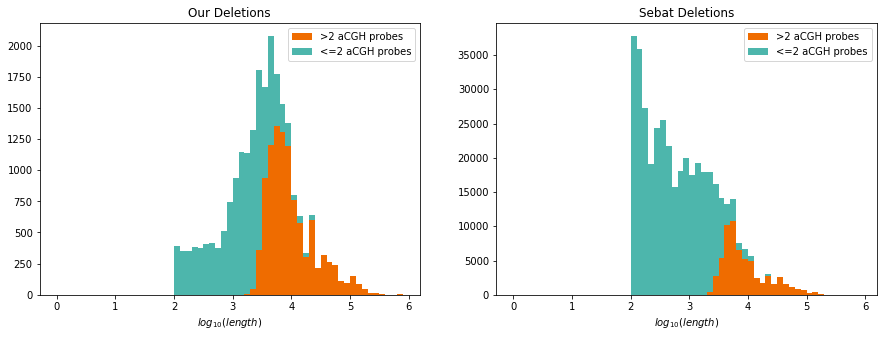

In [225]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Our Deletions')
plt.xlabel('$log_{10}(length)$')
plt.hist([np.log10([d['length'] for d in deletions if d['num_markers_aCGH']>2]), 
          np.log10([d['length'] for d in deletions if d['num_markers_aCGH']<=2])],
          bins=np.arange(0, 6, 0.1), color=colors, label='Our method', stacked=True)
handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= [">2 aCGH probes","<=2 aCGH probes"]
plt.legend(handles, labels)

plt.subplot(1, 2, 2)
plt.title('Sebat Deletions')
plt.xlabel('$log_{10}(length)$')
plt.hist([np.log10([d['length'] for d in sebat_deletions if d['num_markers_aCGH']>2]), 
          np.log10([d['length'] for d in sebat_deletions if d['num_markers_aCGH']<=2])],
         bins=np.arange(0, 6, 0.1), color=colors, label='Our method', stacked=True)
handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= [">2 aCGH probes","<=2 aCGH probes"]
plt.legend(handles, labels)
plt.show()

In [200]:
deletions = [d for d in deletions if d['num_markers_aCGH']>2]
sebat_deletions = [d for d in sebat_deletions if d['num_markers_aCGH']>2]

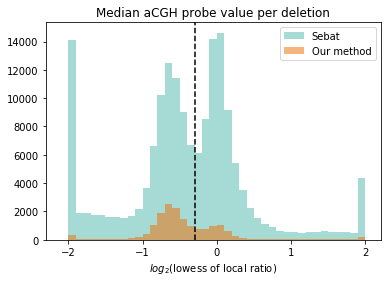

In [226]:
plt.hist(np.clip(np.log2([d['med_aCGH'] for d in sebat_deletions]), -2, 2), 
         alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1), color=colors[1], label='Sebat')
plt.hist(np.clip(np.log2([d['med_aCGH'] for d in deletions]), -2, 2), 
         alpha=0.5, bins=np.arange(-2.1, 2.1, 0.1), color=colors[0], label='Our method')

plt.axvline(-0.3, color='black', linestyle='--')
plt.legend()
plt.xlabel('$log_2$(lowess of local ratio)')
plt.title('Median aCGH probe value per deletion')
plt.show()

In [202]:
our_aCGH = np.log2([d['med_aCGH'] for d in deletions])
sebat_aCGH = np.log2([d['med_aCGH'] for d in sebat_deletions])
                   


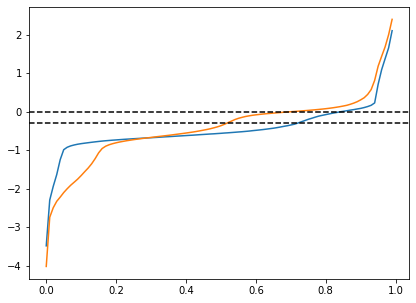

In [204]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 1, 0.01), np.quantile(our_aCGH, np.arange(0, 1, 0.01)))
plt.plot(np.arange(0, 1, 0.01), np.quantile(sebat_aCGH, np.arange(0, 1, 0.01)))
plt.axhline(0, color='black', linestyle='--')
plt.axhline(-0.3, color='black', linestyle='--')

plt.show()

In [205]:
print(np.sum(our_aCGH<-0.3)/len(our_aCGH))
print(np.sum(sebat_aCGH<-0.3)/len(sebat_aCGH))


0.7186092066601372
0.5165384615384615


In [206]:
num_markers_ssc = np.array([d['num_markers'] for d in deletions])
num_markers_sebat = np.array([d['num_markers_ssc'] for d in sebat_deletions])
del_lengths = np.array([x['length'] for x in deletions])
sebat_del_lengths = np.array([x['length'] for x in sebat_deletions])

In [207]:
is_val_acgh = np.array([np.log2(d['med_aCGH'])<-0.3 for d in deletions])
sebat_is_val_acgh = np.array([np.log2(d['med_aCGH'])<-0.3 for d in sebat_deletions])


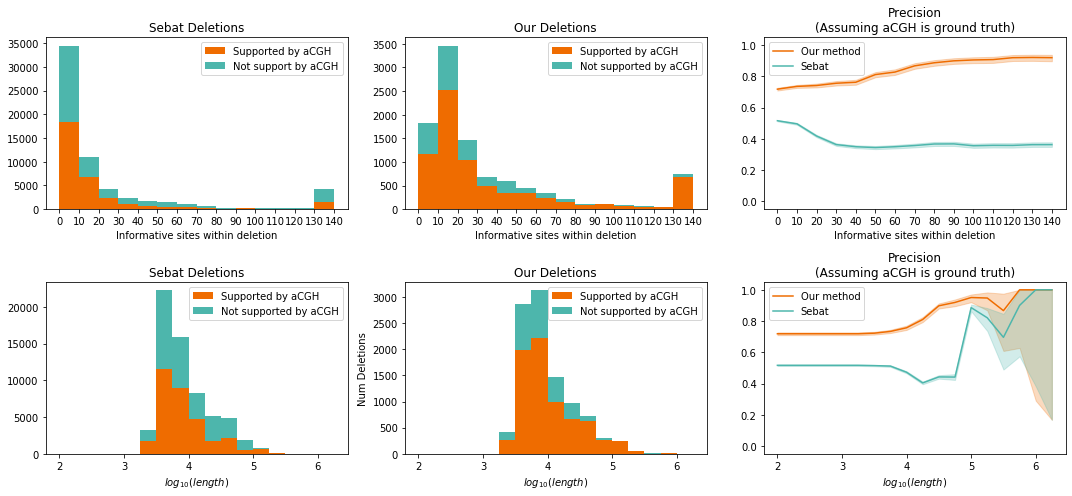

In [209]:
bins = np.arange(0, 150, 10)
plt.figure(figsize=(15, 7))
ax = plt.subplot(2, 3, 1)
plt.hist([np.clip(num_markers_sebat[sebat_is_val_acgh], 0, bins[-2]), np.clip(num_markers_sebat[~sebat_is_val_acgh], 0, bins[-2])], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative sites within deletion')
plt.title('Sebat Deletions')
plt.xticks(bins)

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not support by aCGH"]
plt.legend(handles, labels)

plt.subplot(2, 3, 2, sharex=ax)
plt.hist([np.clip(num_markers_ssc[is_val_acgh], 0, bins[-2]), np.clip(num_markers_ssc[~is_val_acgh], 0, bins[-2])], bins=bins, stacked=True, color=colors)
plt.xlabel('Informative sites within deletion')
plt.title('Our Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not supported by aCGH"]
plt.legend(handles, labels)

plt.subplot(2, 3, 3, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ub, percent_val_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
percent_val_ssc = np.zeros((len(bins),))
percent_val_ssc_ub, percent_val_ssc_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
for i, j in enumerate(bins):
    x = np.sum((num_markers_sebat>=j) & sebat_is_val_acgh)
    n = np.sum((num_markers_sebat>=j))
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    x = np.sum((num_markers_ssc>=j) & is_val_acgh)
    n = np.sum((num_markers_ssc>=j))
    percent_val_ssc[i] = x/n
    percent_val_ssc_ub[i], percent_val_ssc_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')

plt.plot(bins, percent_val_ssc, label='Our method', color=colors[0])
plt.fill_between(bins, percent_val_ssc_ub, percent_val_ssc_lb, color=colors[0], alpha=0.25)
plt.plot(bins, percent_val, label='Sebat', color=colors[1])
plt.fill_between(bins, percent_val_ub, percent_val_lb, color=colors[1], alpha=0.25)
plt.xlabel('Informative sites within deletion')
#plt.ylabel('Fraction of Deletions Validated')
plt.legend()
plt.title('Precision\n(Assuming aCGH is ground truth)')
plt.ylim([-0.05, 1.05])


bins = np.arange(2, 6.5, 0.25)
ax = plt.subplot(2, 3, 4)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(sebat_del_lengths)[sebat_is_val_acgh], 0, 6), np.clip(np.log10(sebat_del_lengths)[~sebat_is_val_acgh], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.title('Sebat Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not supported by aCGH"]
plt.legend(handles, labels)

plt.subplot(2, 3, 5, sharex=ax)
chip_mark_del_n, _, _ = plt.hist([np.clip(np.log10(del_lengths)[is_val_acgh], 0, 6), np.clip(np.log10(del_lengths)[~is_val_acgh], 0, 6)], bins=bins, stacked=True, color=colors)
plt.xlabel('$log_{10}(length)$')
plt.ylabel('Num Deletions')
plt.title('Our Deletions')

handles = [Rectangle((0,0),1,1, color=c, linewidth=0, ec="k") for c in colors]
labels= ["Supported by aCGH","Not supported by aCGH"]
plt.legend(handles, labels)

plt.subplot(2, 3, 6, sharex=ax)
percent_val = np.zeros((len(bins),))
percent_val_ssc = np.zeros((len(bins),))
percent_val_ub, percent_val_lb = np.zeros((len(bins),)), np.zeros((len(bins),))
percent_val_ssc_ub, percent_val_ssc_lb = np.zeros((len(bins),)), np.zeros((len(bins),))

for i, j in enumerate(bins):
    x = np.sum((np.log10(sebat_del_lengths)>=j) & sebat_is_val_acgh)
    n = np.sum((np.log10(sebat_del_lengths)>=j))
    percent_val[i] = x/n
    percent_val_ub[i], percent_val_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')
    
    x = np.sum((np.log10(del_lengths)>=j) & is_val_acgh)
    n = np.sum((np.log10(del_lengths)>=j))
    percent_val_ssc[i] = x/n
    percent_val_ssc_ub[i], percent_val_ssc_lb[i] = sm.stats.proportion_confint(x, n, alpha=0.05, method='agresti_coull')

plt.plot(bins, percent_val_ssc, label='Our method', color=colors[0])
plt.fill_between(bins, percent_val_ssc_ub, percent_val_ssc_lb, color=colors[0], alpha=0.25)
plt.plot(bins, percent_val, label='Sebat', color=colors[1])
plt.fill_between(bins, percent_val_ub, percent_val_lb, color=colors[1], alpha=0.25)

plt.xlabel('$log_{10}(length)$')
plt.legend()
plt.title('Precision\n(Assuming aCGH is ground truth)')
plt.ylim([-0.05, 1.05])

plt.tight_layout()
plt.show()